# Analyze the HNN spring task

In [2]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-spring'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, get_trajectory
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [3]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 1000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'spring',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the dataset

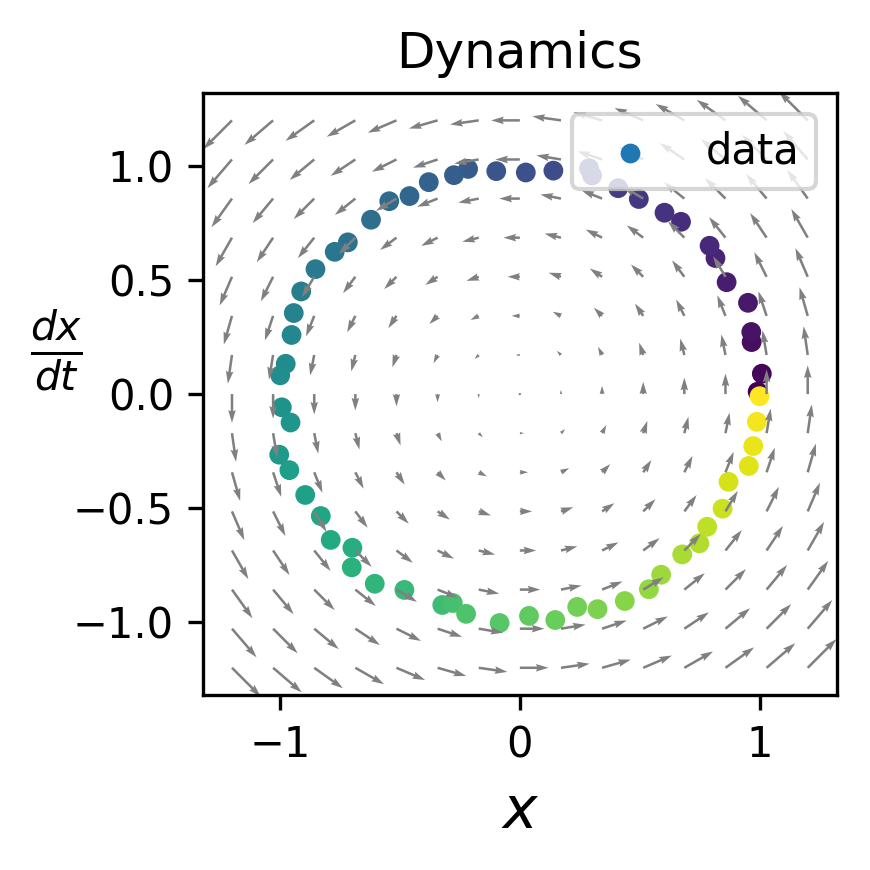

In [4]:
args = ObjectView(get_args())
np.random.seed(args.seed)
field, data = get_field(gridsize=15), get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(radius=1, thetas=[0, 2*np.pi], density=10)
plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/spring-task.png')

## Construct models

In [5]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/spring{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [6]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [7]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [8]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset()
base_field = get_vector_field(base_model, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1., 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Plot results

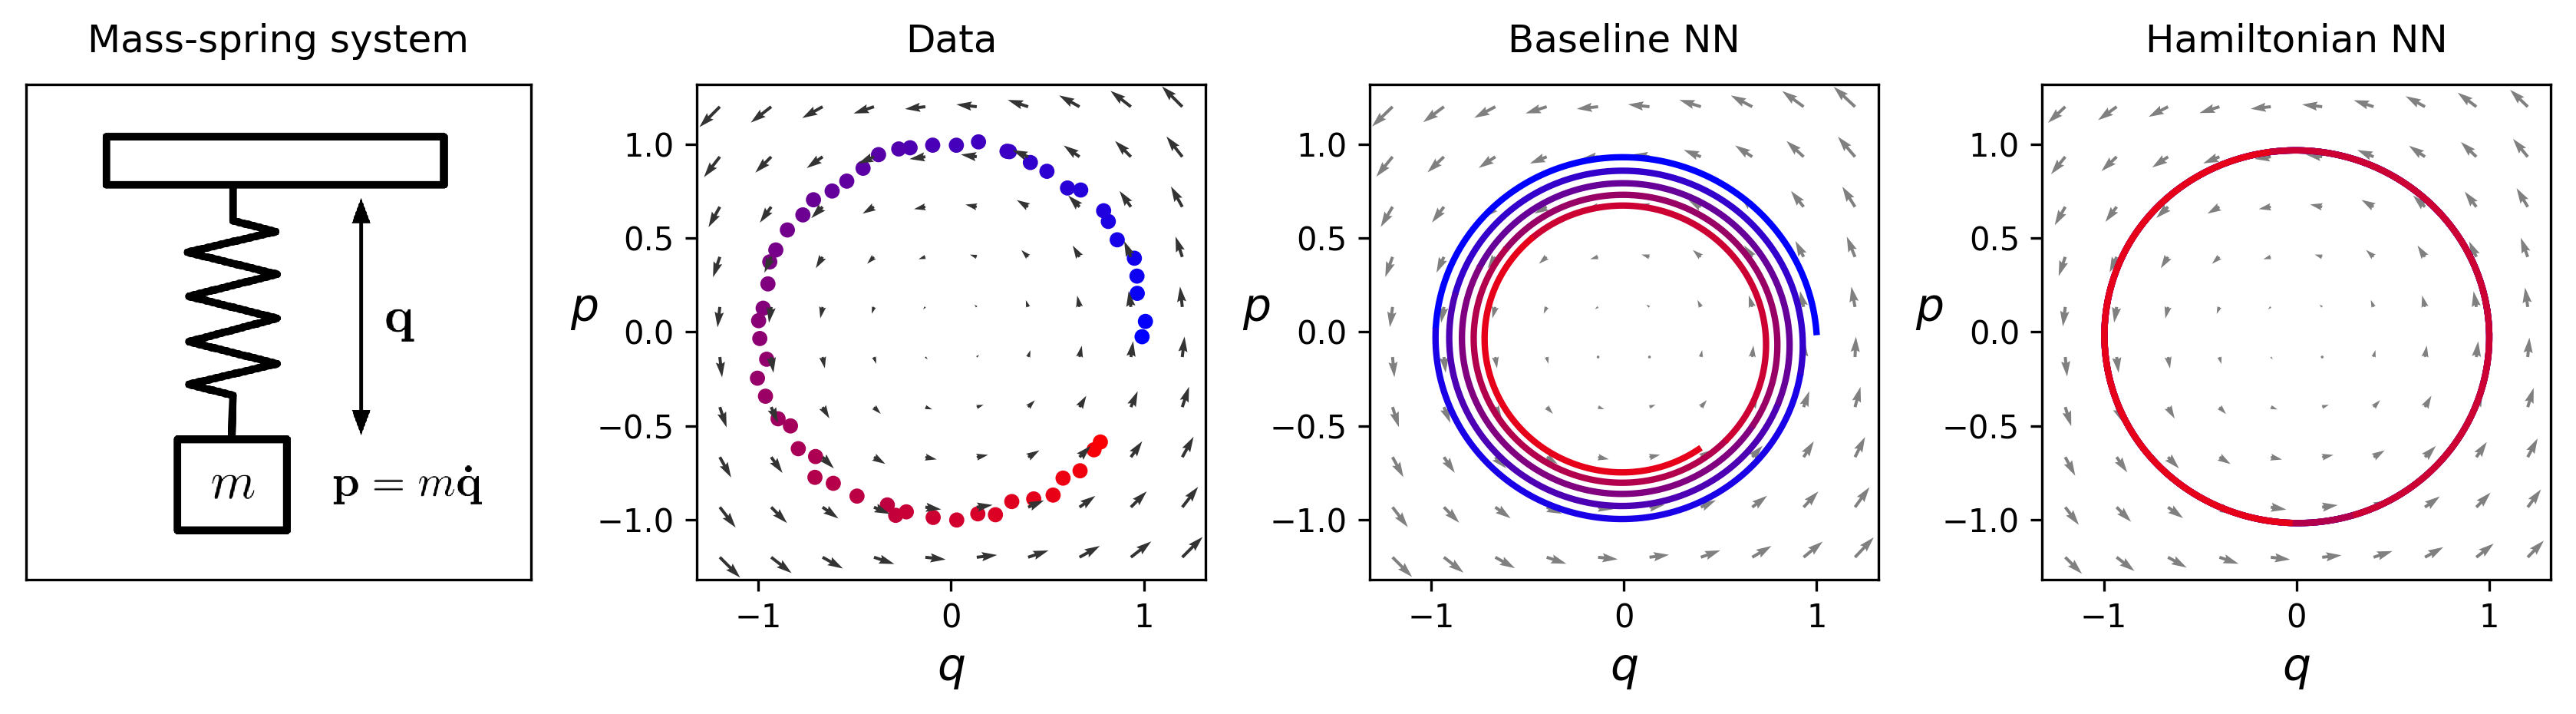

In [9]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3.2), facecolor='white', dpi=DPI)

# plot physical system
fig.add_subplot(1, 4, 1, frameon=True) 
plt.xticks([]) ;  plt.yticks([])
schema = mpimg.imread(EXPERIMENT_DIR + '/mass-spring.png')
plt.imshow(schema)
plt.title("Mass-spring system", pad=10)

# plot dynamics
fig.add_subplot(1, 4, 2, frameon=True)
x, y, dx, dy, t = get_trajectory(radius=1, thetas=[0, 1.8*np.pi], density=10)
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=14, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(1, 4, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
    
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 4, 4, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [10]:
def circular_vector_field(t, x):
    dx = np.fliplr(x.copy().reshape(-1,2))
    dx[:,0] *= -1
    return dx.copy().reshape(*x.shape)

def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_evals=100):
    # integrate along ground truth vector field
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_evals), 'rtol': 1e-12}
    true_path = solve_ivp(fun=circular_vector_field, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    true_dx = circular_vector_field(t=None, x=true_x)

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    base_dx = base_model.time_derivative(_tmp).data.numpy()

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    hnn_dx = hnn_model.time_derivative(_tmp).data.numpy()
    
    return true_x, true_dx, base_x, base_dx, hnn_x, hnn_dx

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

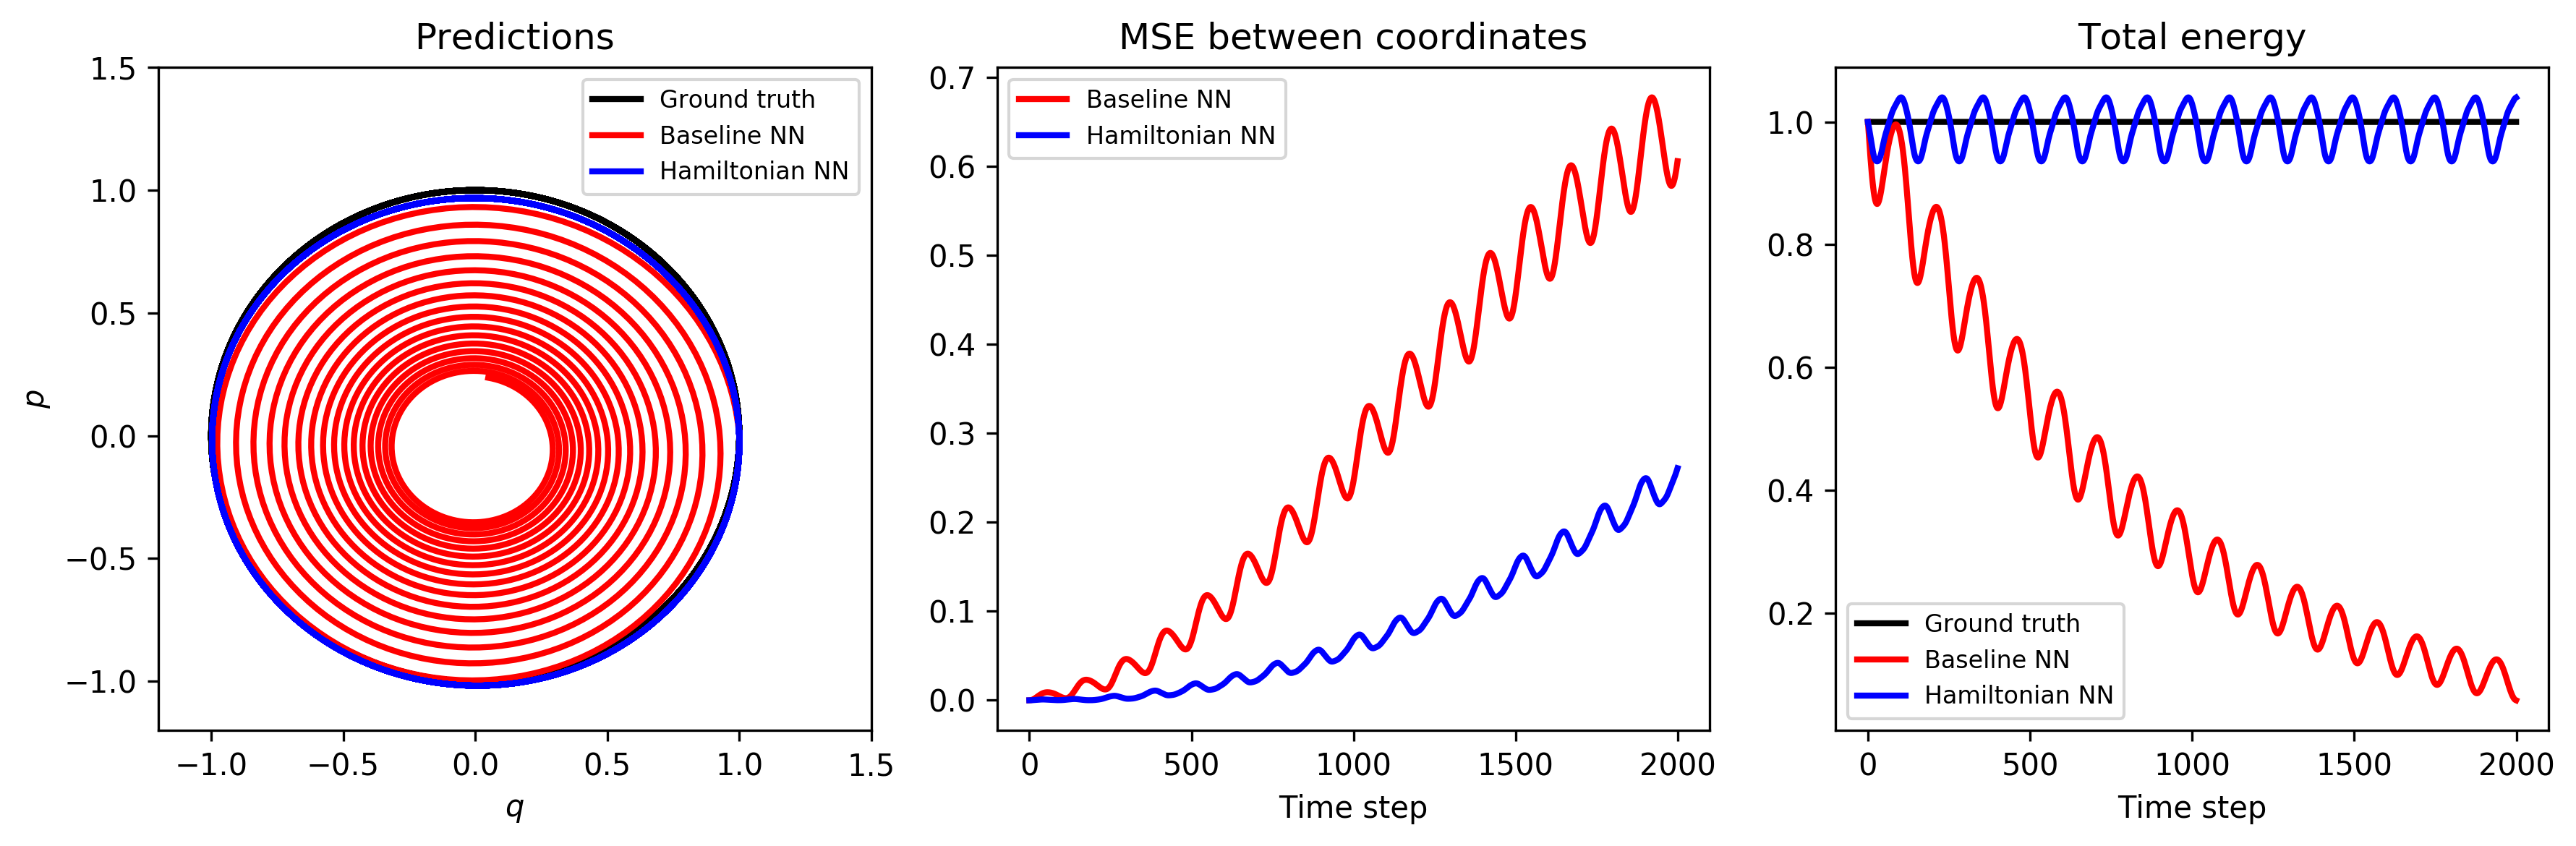

In [11]:
x0 = np.asarray([1, 0])

# integration
vals = integrate_models(x0=x0, t_span=[0,100], t_evals=2000)
[true_x, true_dx, base_x, base_dx, hnn_x, hnn_dx] = vals

# plotting
fig = plt.figure(figsize=[12,4], dpi=DPI)
plt.subplot(1,3,1)
plt.title("Predictions") ; plt.xlabel('$q$') ; plt.ylabel('$p$')
plt.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
plt.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
plt.xlim(-1.2,1.5) ; plt.ylim(-1.2,1.5)
plt.legend(fontsize=8)

plt.subplot(1,3,2)
plt.title("MSE between coordinates") ; plt.xlabel('Time step')
plt.plot(((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=8)

plt.subplot(1,3,3)
plt.title("Total energy")
plt.xlabel('Time step')
plt.plot((true_x**2).sum(1), 'k-', label='Ground truth', linewidth=2)
plt.plot((base_x**2).sum(1), 'r-', label='Baseline NN', linewidth=2)
plt.plot((hnn_x**2).sum(1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=8)

plt.tight_layout() ; plt.show()
fig.savefig('{}/spring-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [12]:
splits = 5
samples = 5
losses = {'base_test' : [], 'hnn_test' : [], 'base_energy' : [], 'hnn_energy' : []}

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*1.8 - .9 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    vals = integrate_models(x0=x0, t_span=[0,100], t_evals=20)
    [true_x, true_dx, base_x, base_dx, hnn_x, hnn_dx] = vals
    
    losses['base_test'] += [ vector_field_loss(base_x, base_dx) ]
    losses['hnn_test'] += [ vector_field_loss(hnn_x, hnn_dx) ]
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [13]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_std = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])

print("Baseline NN test loss: {:.4e} +/- {:.2e}\nHamiltonian NN test loss: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_test']), bootstrap_std(losses['base_test'], splits),
          np.mean(losses['hnn_test']), bootstrap_std(losses['hnn_test'], splits))
     )

print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_std(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_std(losses['hnn_energy'], splits))
     )

Baseline NN test loss: 2.4713e-01 +/- 3.78e-02
Hamiltonian NN test loss: 5.0462e-01 +/- 2.18e-01

Baseline NN energy MSE: 4.7366e-01 +/- 1.63e-01
Hamiltonian NN energy MSE: 2.3771e-03 +/- 7.89e-04
